<a href="https://colab.research.google.com/github/Garvit-Kr/Deep_L/blob/main/MeasureModelPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

# update default font size
import matplotlib
matplotlib.rcParams.update({'font.size':12})

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [ ]:
# their are 4 types of resposes -- in signal detection theory

In [ ]:
'''
                              REALITY
                 |     CAT       |           BOAT
       |---------|---------------|--------------------------
    PR |   CAT   |     HIT       |            FALSE
    ED |         |               |            ALARM
    IC |---------|---------------|-------------------------
    TI |   BOAT  |     MISS      |          CORRECT
    ON |         |               |          REJECTION
'''
# SAME SAME BUT DIFFERENT(TRUE NAME'S)
'''
                                  OBJECTIVE
                                  (REALITY)
                    |     PRESENT     |         ABSENT
          |---------|-----------------|--------------------------
  M    SU |   YES   |     TRUE        |          FALSE
  O    BJ |         |   POSITIVE      |         POSITIVE
  D    EC |---------|-----------------|-------------------------
  E    TI |   NO    |     FALSE       |          TRUE
  L    VE |         |    NEGATIVE     |        NEGATIVE
'''
# Accuracy is useful and informative.
# But it hides possible biases.
# And it does not reveal sensitivity.
# Ergo, accuracy should be supplemented with other measures of performance.


In [ ]:
# their are 4 types of resposes

# 1. ACCURACY --> {TRUE POSITIVE + TRUE NEGATIVE}
#                 overall model performace ignoring allcategories and sample size

#                 formula : TRUE POSITIVE + TRUE NEGATIVE / SAMPLE SIZE
# 2. PRECISION --> {TRUE POSITIVE + fALSE POSITIVE}
#                  includes cost for 'yes' biases.usefull when false postives are bad like cancer detection

#                  formula : TRUE POSITIVE / T.NO. OF 'YES' PREDICTION           **YES IS T.NO. OF TP+FP
# 3. RECALL -->{TRUE POSITIVE + FALSE NEGATIVE}
#               includes cost for 'NO' biases.usefull when false negatives are bad like cancer detection

#               formula : TRUE POSITIVES / T.NO. OF PRESENTS                    ** SENSITIVITY FORMULA
# 4.F1 (PRECISION AND RECALL) --> {TRUE POSITIVE + FALSE NEGATIVE + FALSE POSITIVE}
#                                 balance between precision and recall.F1 is high with few mistakes.

#                                 formula : TRUE POSITIVE / TP + ((FP + FN)/2)


#ARPF(fo short)

In [ ]:
## run experiment

# number of 'trials' in the experiment
N = 50 # actual trials is 2N

# number of experiment repetitions
numExps = 10000

# initialize
accuracy  = np.zeros(numExps)
precision = np.zeros(numExps)
recall    = np.zeros(numExps)
F1score   = np.zeros(numExps)


### run the experiment!
for expi in range(numExps):

  # generate data
  TP = np.random.randint(1,N)  # true positives,  aka hits
  FN = N-TP                    # false negatives, aka misses
  TN = np.random.randint(1,N)  # true negatives,  aka correct rejections
  FP = N-TN                    # false positives, aka false alarms


  ### the four performance measures discussed in lecture

  # accuracy
  accuracy[expi]  = (TP+TN) / (2*N)

  # precision
  precision[expi] = TP / (TP+FP)

  # recall
  recall[expi]    = TP / (TP+FN)

  # Fscore
  F1score[expi]   = TP / (TP+(FP+FN)/2)


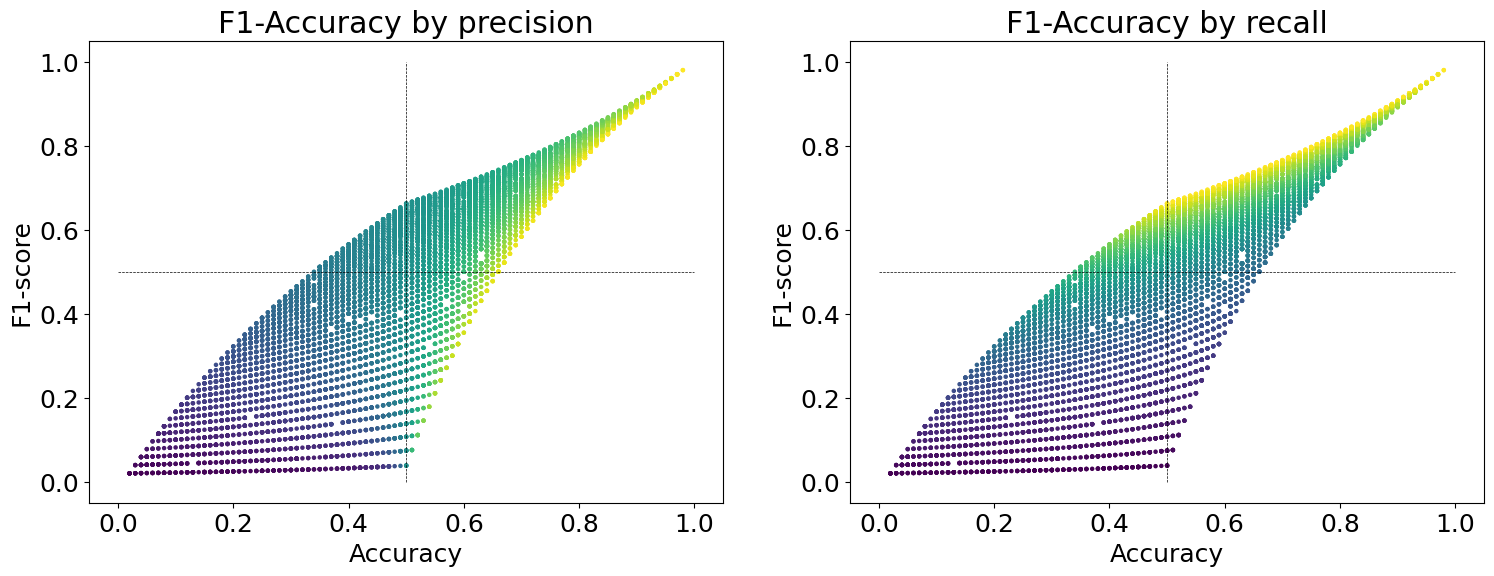

In [ ]:
## let's see how they relate to each other!

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].scatter(accuracy,F1score,s=5,c=precision)
ax[0].plot([0,1],[.5,.5],'k--',linewidth=.5)
ax[0].plot([.5,.5],[0,1],'k--',linewidth=.5)
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('F1-score')
ax[0].set_title('F1-Accuracy by precision')


ax[1].scatter(accuracy,F1score,s=5,c=recall)
ax[1].plot([0,1],[.5,.5],'k--',linewidth=.5)
ax[1].plot([.5,.5],[0,1],'k--',linewidth=.5)
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('F1-score')
ax[1].set_title('F1-Accuracy by recall')

plt.show()

EXAMPLE 1 (WINE QUALITY)

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

<ipython-input-13-6f5cb70bcde3>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
<ipython-input-13-6f5cb70bcde3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [ ]:
# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [ ]:
# create and train a model
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()


In [ ]:
# predictions for training data
train_predictions = winenet(train_loader.dataset.tensors[0])
train_predictions

# predictions for test data
test_predictions = winenet(test_loader.dataset.tensors[0])
test_predictions

tensor([[-1.9421e+00],
        [ 8.2631e-01],
        [ 6.2807e+00],
        [-3.6367e+00],
        [-3.2329e+00],
        [ 5.2620e+00],
        [ 1.0907e+00],
        [ 4.4013e+00],
        [-2.9710e+00],
        [ 5.0079e-01],
        [ 4.5406e+00],
        [-9.3076e-01],
        [ 5.9882e+00],
        [-8.9848e+00],
        [ 1.5465e+00],
        [ 1.0944e+00],
        [-4.0104e+00],
        [-7.7975e+00],
        [ 7.0738e+00],
        [ 4.9675e+00],
        [ 3.9217e+00],
        [ 4.2632e+00],
        [ 2.0279e+00],
        [ 2.7293e+00],
        [-3.9783e+00],
        [ 2.6165e+00],
        [-6.2990e+00],
        [-3.8003e+00],
        [ 2.2756e+00],
        [ 6.4783e+00],
        [ 3.4476e+00],
        [ 1.0765e+01],
        [ 5.5441e+00],
        [-4.7942e+00],
        [-6.6804e+00],
        [ 5.8232e-01],
        [-1.7827e+00],
        [-5.9060e+00],
        [ 4.9537e+00],
        [ 6.6646e+00],
        [-4.7078e+00],
        [-3.3422e-01],
        [-1.0305e+01],
        [-2

In [ ]:
# NEW! using scikitlearn to compute ARPF
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions>0)


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions>0)

ValueError: Unsupported device for NumPy: device(type='cpu')

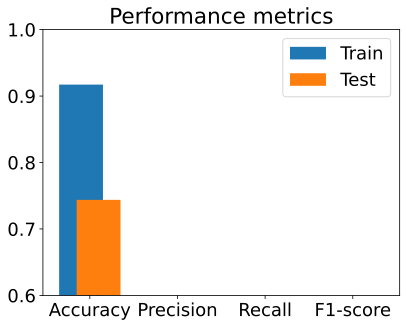

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

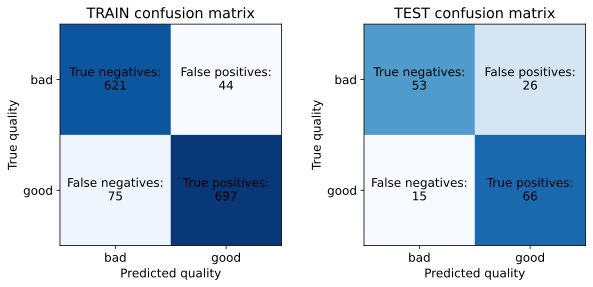

array([[621,  44],
       [ 75, 697]])

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0)
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad','good'])
ax[0].set_yticklabels(['bad','good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')
plt.show()

trainConf

EXAMPLE 2 (MNIST DATASET)

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


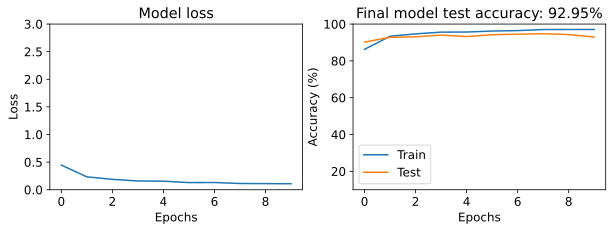

In [ ]:
# build and train the model
trainAcc,testAcc,losses,net = function2trainTheModel()


# visualization starts here
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat,axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
test_predictions

tensor([6, 0, 3,  ..., 5, 2, 4])

In [ ]:
# Brief aside on computing precision et al. in multiclass data:
# There are now 10 classes, so there are 10 precision values.


## option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)

## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')

## option 3: compute average precision, unweighted (same as 'weighted' if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')

0.9654212724045982

In [ ]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions,average='weighted')


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions,average='weighted')

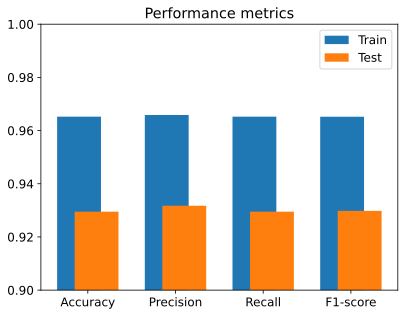

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

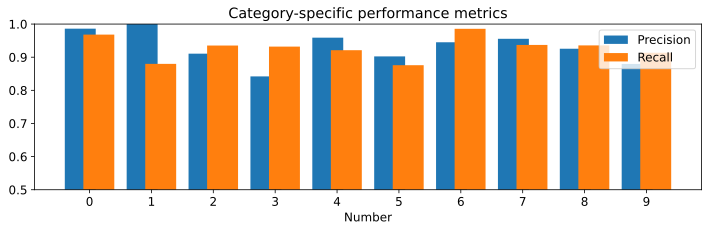

In [ ]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

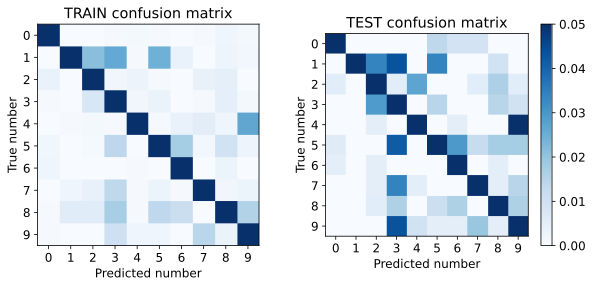

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

In [ ]:
# Possible causes of test>train

# Random luck with small samples (nonsystematic).
# Test data are systematically easier to categorize.
# Test data are not normalized. Accuracy was horrible in the first batch of training and improved fast.
# Dropout regularization (left on during testing).
# Bug in the code ("test" data taken from training?).

# ----------------------------------------------------------------------------
# What to do with "inverse" results?

# Small differences (few %): probably not a big deal.
# Huge differences (e.g., 60% vs. 99%): probably a bug in the code .
# "Medium" differences: Check for too much regularization that unfairly hurts training; check that dropout and batchnorm are off during test; simplify the model architecture.